# Rainfall Trends and Patterns in Dublin (Ringsend)

The final project for Programming for Data Analytics '24-'25

Author: Atacan Buyuktalas

## Introduction

- Objective

    Rainfall plays a vital role in understanding weather patterns and their impact on the environment. This project analyzes rainfall data from the Dublin (Ringsend) weather station, spanning 1941 to August 2024, to uncover trends, seasonal patterns, and extreme rainfall events.

- Key Questions

    1.	Analyze annual and monthly rainfall trends.
	2.	Explore correlations between rainfall metrics, such as the greatest daily fall (gdf), number of rain days (rd), and wet days (wd).
	3.	Predict future rainfall using historical data.

## Data Loading and Cleaning

The data set it taken from [Met Eireann](https://www.met.ie/climate/available-data/historical-data). 

In [31]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

In [32]:
# Read the data
file_path = 'data/dublin_1941_2024.csv'
df = pd.read_csv(file_path, skiprows=13)

# Display the first 5 rows of the data
print(df.head())

# Check for missing values and data types
print(df.info())

   year  month  ind   rain   gdf  rd  wd
0  1941      1    0  112.8  13.0  18  18
1  1941      2    0   69.5  13.0  22  15
2  1941      3    0  111.0  50.0  21  13
3  1941      4    0   68.6  16.5  15  12
4  1941      5    0   66.4  20.1  13  10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    971 non-null    int64 
 1   month   971 non-null    int64 
 2   ind     971 non-null    int64 
 3   rain    971 non-null    object
 4   gdf     971 non-null    object
 5   rd      971 non-null    object
 6   wd      971 non-null    object
dtypes: int64(3), object(4)
memory usage: 53.2+ KB
None


In [33]:
# Convert columns to appropriate numeric types
df['rain'] = pd.to_numeric(df['rain'], errors='coerce')
df['gdf'] = pd.to_numeric(df['gdf'], errors='coerce')
df['rd'] = pd.to_numeric(df['rd'], errors='coerce')
df['wd'] = pd.to_numeric(df['wd'], errors='coerce')

### Convert date columns

- Used [`to_datetime`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to create a datetime column, also used [`DataFrame.assign(day=1)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html#pandas.DataFrame.assign) to complete the date. 

In [34]:
# Create a datetime column for easy plotting and analysis
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)

# Drop unnecessary columns
df = df.drop(columns=['ind'])

print(df.head())

            year  month   rain   gdf    rd    wd
date                                            
1941-01-01  1941      1  112.8  13.0  18.0  18.0
1941-02-01  1941      2   69.5  13.0  22.0  15.0
1941-03-01  1941      3  111.0  50.0  21.0  13.0
1941-04-01  1941      4   68.6  16.5  15.0  12.0
1941-05-01  1941      5   66.4  20.1  13.0  10.0


### Handling missing values

- Used [`replace()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html#pandas.DataFrame.replace) operator to reveal null values and counting them using [`isnull()`](https://pandas.pydata.org/docs/reference/api/pandas.isnull.html#pandas-isnull) and `sum()`.

- Handle missing values, especially spaces represented as missing data.

In [37]:
# Replace missing values with NaN
df.replace(' ', np.nan, inplace=True)

# Check for missing values
print(df.isnull().sum())

print(df.info())

year       0
month      0
rain      50
gdf      104
rd        91
wd        91
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 1941-01-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    971 non-null    int64  
 1   month   971 non-null    int64  
 2   rain    921 non-null    float64
 3   gdf     867 non-null    float64
 4   rd      880 non-null    float64
 5   wd      880 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 53.1 KB
None


I avoid to fill missing values for 'Greatest Daily Fall' (gdf) as it represents the maximum daily rainfall in a month, which is not a cumulative or trend-driven metric like rain, rd, or wd. Hence, I aim to preserve the integrity of the dataset. This signals that these values are unknown, rather than assuming a pattern that might not exist.

In [38]:
# Fill missing values using an interpolation method
df['rain'] = df['rain'].interpolate(method='time')
df['rd'] = df['rd'].interpolate(method='time')
df['wd'] = df['wd'].interpolate(method='time')

#Sanity check
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 971 entries, 1941-01-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    971 non-null    int64  
 1   month   971 non-null    int64  
 2   rain    971 non-null    float64
 3   gdf     867 non-null    float64
 4   rd      971 non-null    float64
 5   wd      971 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 53.1 KB
None


## Exploratory Data Analysis

### Annual Rainfall Trends

Annual rainfall trends provide insight into long-term changes.

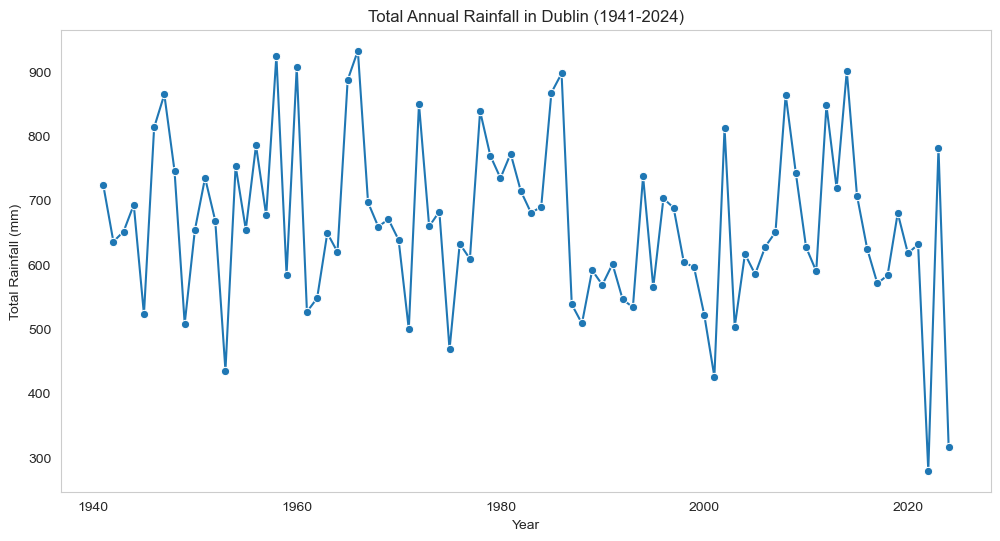

In [39]:
# Calculate total annual rainfall
annual_rainfall = df.groupby(df.index.year)['rain'].sum()

# Plot the total annual rainfall
plt.figure(figsize=(12, 6))
sns.lineplot(x=annual_rainfall.index, y=annual_rainfall.values, marker='o')
plt.title('Total Annual Rainfall in Dublin (1941-2024)')
plt.xlabel('Year')
plt.ylabel('Total Rainfall (mm)')
plt.grid()
plt.show()

### Monthly Rainfall Patterns

Monthly analysis helps us to understand how rainfall varies throughout the year. 

- This plot reveals the months with the highest and lowest average rainfall.

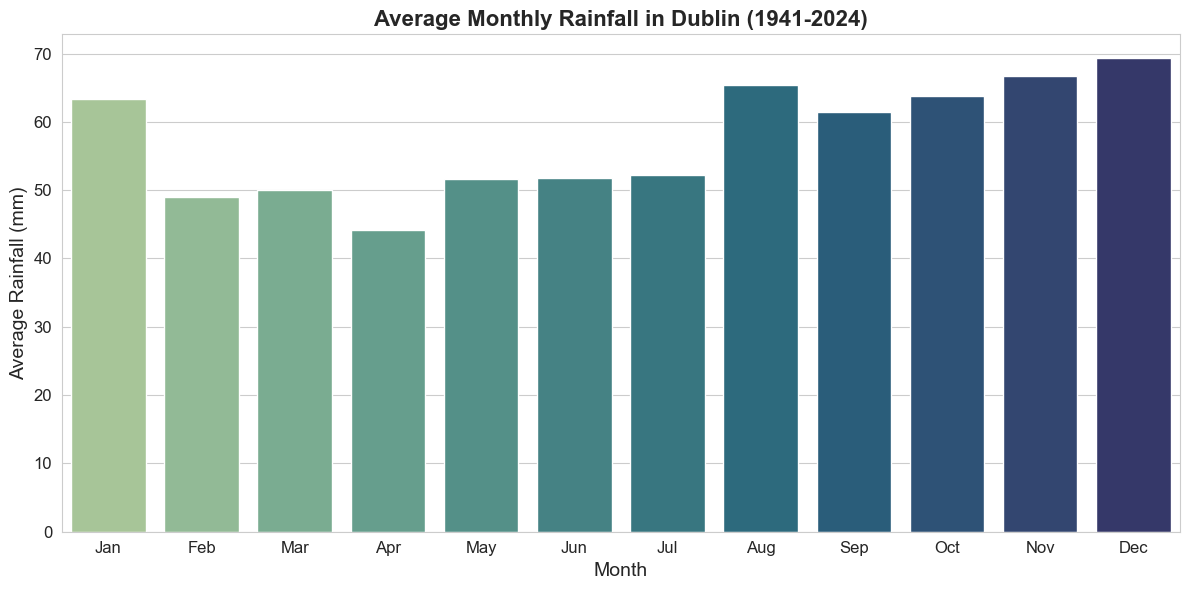

In [40]:
# Calculate the avarage monthly rainfall
monthly_rainfall = df.groupby(df.index.month)['rain'].mean()

# Plot the average monthly rainfall
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_rainfall.index, y=monthly_rainfall.values, palette='crest', hue=monthly_rainfall.index, legend=False)
plt.title('Average Monthly Rainfall in Dublin (1941-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Rainfall (mm)', fontsize=14)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Extreme Rainfall Events

Identify the top 10 greatest daily rainfall events. This plot highlights the years with the most extreme daily rainfall events.


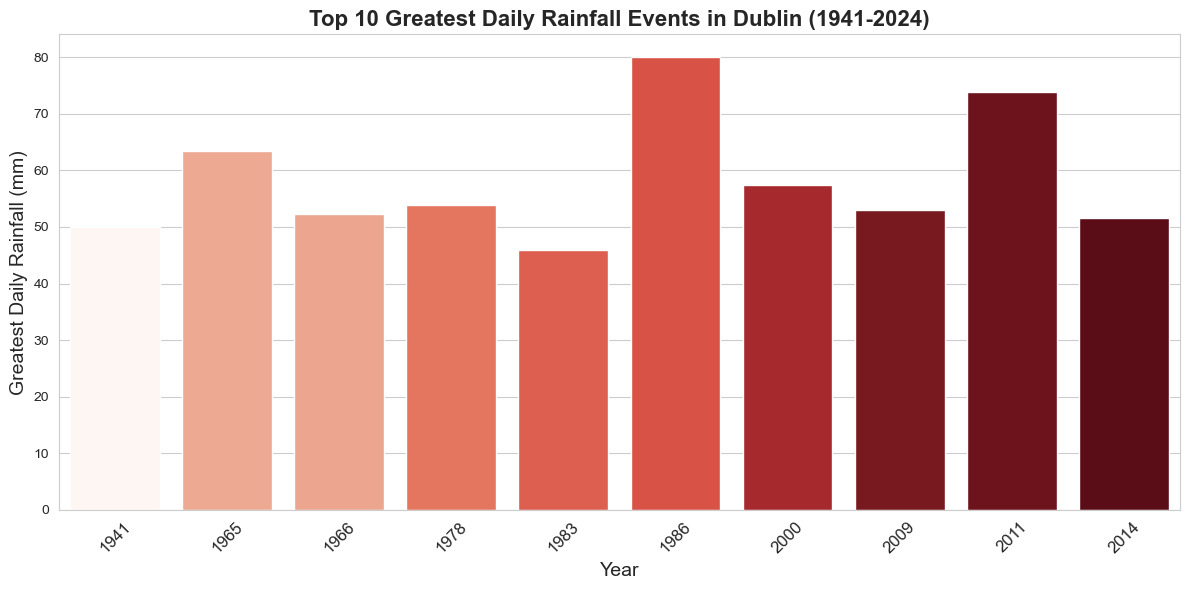

In [45]:
# Extract top 10 greatest daily rainfall values
top_10_gdf = df.nlargest(10, 'gdf')

# Plot the top 10 greatest daily rainfall values
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_gdf, x=top_10_gdf.index.year, y='gdf', palette='Reds', hue=top_10_gdf.index.year, legend=False)
plt.title('Top 10 Greatest Daily Rainfall Events in Dublin (1941-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Greatest Daily Rainfall (mm)', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis

Explore relationship between rainfall metrics. The heatmap shows the strength of relationships between rainfall (rain), greatest daily fall (gdf), rain days (rd), and wet days (wd).

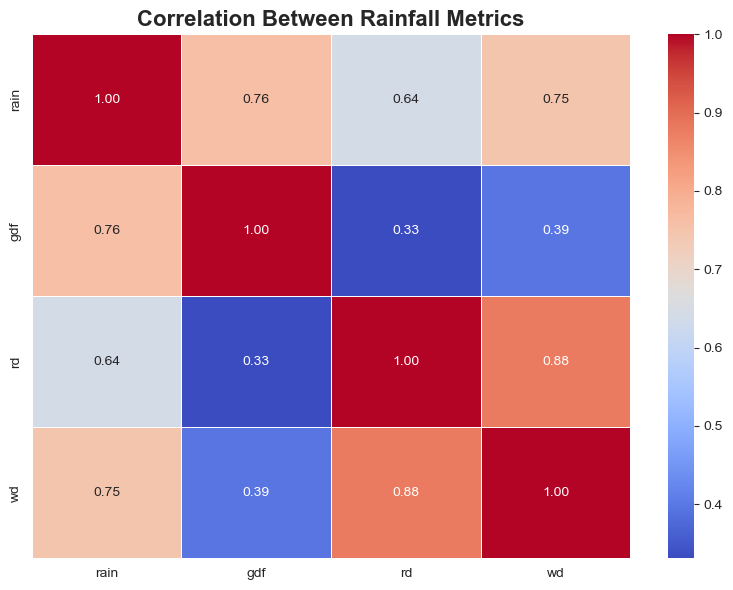

In [46]:
# Correlation heatmap
corr_matrix = df[['rain', 'gdf', 'rd', 'wd']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Rainfall Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Prediction Analysis